# **Recap of [Lesson 4](https://colab.research.google.com/drive/1mfqZulsuFDc7h27d6joe2_Dduvl1uM-2#forceEdit=true&sandboxMode=true) 👩‍💻🚀**

1. Listed all available verified sources;
2. Initialized `github_api` verified source;
3. Explored built-in `rest_api` source.
4. Explored built-in `sql_database` source.
5. Explored built-in `filesystem` source.
6. Learned how to switch between destinations.

---

# **Write Disposition and Incremental Loading** ⚙️🧠

**Here, you will learn:**
- `dlt` write dispositions:
  - Append
  - Replace
  - Merge
- What incremental loading is
- How to update and deduplicate your data

---
## **`dlt` write dispositions**

Write disposition in the context of the dlt library defines how the data should be written to the destination. There are three types of write dispositions:

* **Append**: This is the **default** disposition. It will append the data to the existing data in the destination.

* **Replace**: This disposition replaces the data in the destination with the data from the resource. It **deletes** all the data and **recreates** the schema before loading the data.

* **Merge**: This write disposition merges the data from the resource with the data at the destination. For the merge disposition, you need to specify a `primary_key` for the resource.

The write disposition you choose depends on the dataset and how you can extract it. For more details, you can refer to the [Incremental loading page](https://dlthub.com/docs/general-usage/incremental-loading).



A `write_disposition` in `dlt` can specified in the resource decorator:

```python
@dlt.resource(write_disposition="append")
def my_resource():
  ...
  yield data
```

Or directly in the pipeline run:

```python
load_info = pipeline.run(my_resource, write_disposition="replace")
```

> In case you specify both, the write disposition specified at the pipeline run level will override the write disposition specified at the resource level.

### **0. Install dlt**

Install `dlt` with DuckDB as a destination as per usual:

In [1]:
%%capture
!pip install "dlt[duckdb]"

---
### **1. Append**

As we already have said `append` is a default loading behavior. Now we will explore how this write disposition works.

Let's remember our Quick Start data sample with pokemons:

In [2]:
# Sample data containing pokemon details
data = [
    {"id": "1", "name": "bulbasaur", "size": {"weight": 6.9, "height": 0.7}},
    {"id": "4", "name": "charmander", "size": {"weight": 8.5, "height": 0.6}},
    {"id": "25", "name": "pikachu", "size": {"weight": 6, "height": 0.4}},
]

We create dlt pipeline as usual and load this data into DuckDB.

In [3]:
import dlt

@dlt.resource(
    name='pokemon',
    write_disposition='append', # <--- add new argument into decorator
)
def pokemon():
    yield data


pipeline = dlt.pipeline(
    pipeline_name="poke_pipeline",
    destination="duckdb",
    dataset_name="pokemon_data",
)

load_info = pipeline.run(pokemon)
print(load_info)

# explore loaded data
pipeline.dataset(dataset_type="default").pokemon.df()

Pipeline poke_pipeline load step completed in 0.23 seconds
1 load package(s) were loaded to destination duckdb and into dataset pokemon_data
The duckdb destination used duckdb:////content/poke_pipeline.duckdb location to store data
Load package 1741694737.4822986 is LOADED and contains no failed jobs


,id,name,size__weight,size__height,_dlt_load_id,_dlt_id
0,1,bulbasaur,6.9,0.7,1741694737.4822986,7HMeYJwzMAmr4A
1,4,charmander,8.5,0.6,1741694737.4822986,Ax38hWdYTky/DA
2,25,pikachu,6.0,0.4,1741694737.4822986,4lXIii0tjMAXew


Run this example **twice**, and you'll notice that each time a copy of the data is added to your tables. We call this load mode **append**. It is very useful.

Example use case: when you have a new folder created daily with json file logs, and you want to ingest them incrementally.

In [4]:
load_info = pipeline.run(pokemon)
print(load_info)

# explore loaded data
pipeline.dataset(dataset_type="default").pokemon.df()

Pipeline poke_pipeline load step completed in 0.54 seconds
1 load package(s) were loaded to destination duckdb and into dataset pokemon_data
The duckdb destination used duckdb:////content/poke_pipeline.duckdb location to store data
Load package 1741694744.8075423 is LOADED and contains no failed jobs


,id,name,size__weight,size__height,_dlt_load_id,_dlt_id
0,1,bulbasaur,6.9,0.7,1741694737.4822986,7HMeYJwzMAmr4A
1,4,charmander,8.5,0.6,1741694737.4822986,Ax38hWdYTky/DA
2,25,pikachu,6.0,0.4,1741694737.4822986,4lXIii0tjMAXew
3,1,bulbasaur,6.9,0.7,1741694744.8075423,/5p/N2CoijUenw
4,4,charmander,8.5,0.6,1741694744.8075423,O9GVbjHJU+6NjQ
5,25,pikachu,6.0,0.4,1741694744.8075423,aPzCmWupXkyRNg


---
### **2. Replace**

Perhaps this duplicated data is not what you want to get in your work projects. For example, if your data was updated, how we can refresh it in the database? One method is to tell dlt to **replace** the data in existing tables by using **write_disposition**.

In [5]:
import dlt

@dlt.resource(
    name='pokemon',
    write_disposition='replace', # <--- change 'append' to 'replace'
)
def pokemon():
    yield data


pipeline = dlt.pipeline(
    pipeline_name="poke_pipeline",
    destination="duckdb",
    dataset_name="pokemon_data",
)

load_info = pipeline.run(pokemon)
print(load_info)

# explore loaded data
pipeline.dataset(dataset_type="default").pokemon.df()

Pipeline poke_pipeline load step completed in 0.29 seconds
1 load package(s) were loaded to destination duckdb and into dataset pokemon_data
The duckdb destination used duckdb:////content/poke_pipeline.duckdb location to store data
Load package 1741694751.636608 is LOADED and contains no failed jobs


,id,name,size__weight,size__height,_dlt_load_id,_dlt_id
0,1,bulbasaur,6.9,0.7,1741694751.636608,ddyqps7fgM8WSQ
1,4,charmander,8.5,0.6,1741694751.636608,P+AnX0M/+zae8w
2,25,pikachu,6.0,0.4,1741694751.636608,8NmnYx+VA4dxCw


Run it again:

In [6]:
load_info = pipeline.run(pokemon)
print(load_info)

# explore loaded data
pipeline.dataset(dataset_type="default").pokemon.df()

Pipeline poke_pipeline load step completed in 0.14 seconds
1 load package(s) were loaded to destination duckdb and into dataset pokemon_data
The duckdb destination used duckdb:////content/poke_pipeline.duckdb location to store data
Load package 1741694757.5503232 is LOADED and contains no failed jobs


,id,name,size__weight,size__height,_dlt_load_id,_dlt_id
0,1,bulbasaur,6.9,0.7,1741694757.5503232,KhZbqJOnmcqLgA
1,4,charmander,8.5,0.6,1741694757.5503232,cf+UYprb/FfW2Q
2,25,pikachu,6.0,0.4,1741694757.5503232,kx4ZmAupvgYptQ


TAADA! No duplicates, your data was [fully refreshed](https://dlthub.com/docs/general-usage/full-loading).

---
### **3. [Merge](https://dlthub.com/docs/general-usage/incremental-loading#merge-incremental-loading)**

Consider a scenario where the data in the source has been updated, but you want to avoid reloading the entire dataset.



Merge write disposition is used to merge new data into the destination, using a `merge_key` and/or **deduplicating**/**upserting** new data using a `primary_key`.



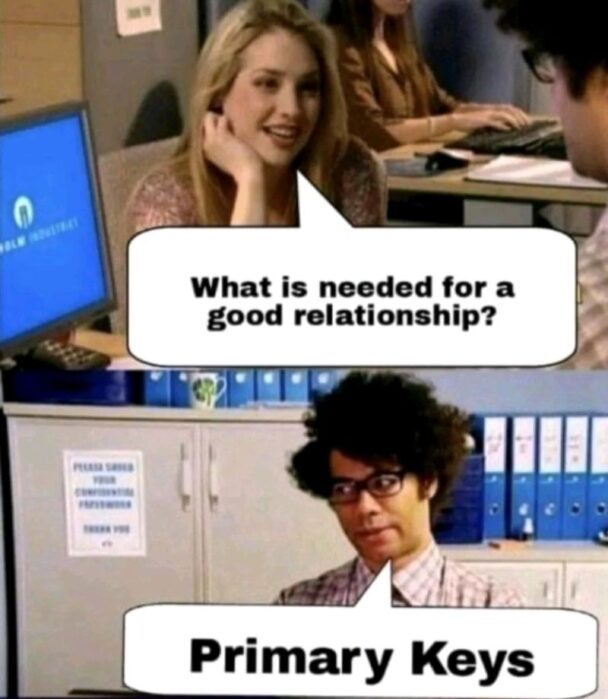


The **merge** write disposition can be useful in several situations:

1.  If you have a dataset where records are frequently updated and you want to reflect these changes in your database, the `merge` write disposition can be used. It will **update the existing records** with the new data instead of creating duplicate entries.

2. If your data source occasionally sends **duplicate records**, the merge write disposition can help handle this. It uses a `primary_key` to identify unique records, so if a duplicate record (with the same `primary_key`) is encountered, it will be merged with the existing record instead of creating a new one.

3. If you are dealing with **Slowly Changing Dimensions** (SCD) where the attribute of a record changes over time and you want to maintain a history of these changes, you can use the `merge` write disposition with the scd2 strategy.


When using the merge disposition, you need to specify a `primary_key` or `merge_key` for the resource.


In [7]:
import dlt

@dlt.resource(
    name='pokemon',
    write_disposition='merge', # <--- change 'replace' to 'merge'
    primary_key="id", # <--- add primary_key
)
def pokemon():
    yield data


pipeline = dlt.pipeline(
    pipeline_name="poke_pipeline_merge",
    destination="duckdb",
    dataset_name="pokemon_data",
)

load_info = pipeline.run(pokemon)
print(load_info)

# explore loaded data
pipeline.dataset(dataset_type="default").pokemon.df()

Pipeline poke_pipeline_merge load step completed in 0.37 seconds
1 load package(s) were loaded to destination duckdb and into dataset pokemon_data
The duckdb destination used duckdb:////content/poke_pipeline_merge.duckdb location to store data
Load package 1741694773.8104784 is LOADED and contains no failed jobs


,id,name,size__weight,size__height,_dlt_load_id,_dlt_id
0,25,pikachu,6.0,0.4,1741694773.8104784,YNqK8IGuLliC0w
1,4,charmander,8.5,0.6,1741694773.8104784,Bj0d3ox+sZhFeQ
2,1,bulbasaur,6.9,0.7,1741694773.8104784,q98EmzJOcke6Zw


The merge write disposition can be used with three different strategies:

* delete-insert (default strategy)
* scd2
* upsert

---
##  **Incremental Loading**


Incremental loading is the act of loading only new or changed data and not old records that we already loaded.

Imagine you’re a Pokémon trainer trying to catch ‘em all. You don’t want to keep visiting the same old PokéStops, catching the same old Bulbasaurs—you only want to find new and exciting Pokémon that have appeared since your last trip. That’s what incremental loading is all about: collecting only the new data that’s been added or changed, without wasting your Poké Balls (or database resources) on what you already have.

In this example, we have a dataset of Pokémon, each with a **unique ID**, their **name**, **size** (height and weight), and **when** they were "caught" (`created_at` field).

### **Step 1: Adding the `created_at` Field**

In [8]:
# We added `created_at` field to the data
data = [
    {
        "id": "1",
        "name": "bulbasaur",
        "size": {"weight": 6.9, "height": 0.7},
        "created_at": "2024-12-01"    # <------- new field
    },
    {
        "id": "4",
        "name": "charmander",
        "size": {"weight": 8.5, "height": 0.6},
        "created_at": "2024-09-01"    # <------- new field
    },
    {
        "id": "25",
        "name": "pikachu",
        "size": {"weight": 6, "height": 0.4},
        "created_at": "2023-06-01"    # <------- new field
    },
]

**The goal**: Load only Pokémon caught after January 1, 2024, skipping the ones you already have.

### **Step 2: Defining the incremental logic**

Using `dlt`, we set up an [incremental filter](https://www.google.com/url?q=https://dlthub.com/docs/general-usage/incremental-loading%23incremental-loading-with-a-cursor-field&sa=D&source=editors&ust=1734717286675253&usg=AOvVaw3rAF3y3p86sGt49ImCTgon) to only fetch Pokémon caught after a certain date:
```python
cursor_date = dlt.sources.incremental("created_at", initial_value="2024-01-01")
```
This tells `dlt`:
- **Start date**: January 1, 2024 (`initial_value`).
- **Field to track**: `created_at` (our timestamp).

As you run the pipeline repeatedly, `dlt` will keep track of the latest `created_at` value processed. It will skip records older than this date in future runs.


In [9]:
import dlt

@dlt.resource(
    name="pokemon",
    write_disposition="append",
)
def pokemon(cursor_date=dlt.sources.incremental("created_at", initial_value="2024-01-01")):
    yield data


We use the `@dlt.resource` decorator to declare table **name** to which data will be loaded and **write disposition**, which is **append** by default.

### **Step 3: Running the pipeline**
Finally, we run our pipeline and load the fresh Pokémon data:

In [10]:
pipeline = dlt.pipeline(
    pipeline_name="poke_pipeline_incremental",
    destination="duckdb",
    dataset_name="pokemon_data",
)

load_info = pipeline.run(pokemon)
print(load_info)

# explore loaded data
pipeline.dataset(dataset_type="default").pokemon.df()

Pipeline poke_pipeline_incremental load step completed in 0.35 seconds
1 load package(s) were loaded to destination duckdb and into dataset pokemon_data
The duckdb destination used duckdb:////content/poke_pipeline_incremental.duckdb location to store data
Load package 1741694823.86687 is LOADED and contains no failed jobs


,id,name,size__weight,size__height,created_at,_dlt_load_id,_dlt_id
0,1,bulbasaur,6.9,0.7,2024-12-01,1741694823.86687,Lkb5h9OSTD/S+g
1,4,charmander,8.5,0.6,2024-09-01,1741694823.86687,WG3wEXPm/YZ3Hw


This:
1. Loads **only Charmander and Bulbasaur** (caught after 2024-01-01).
2. Skips Pikachu because it’s old news.

Only data for 2024 year was loaded.

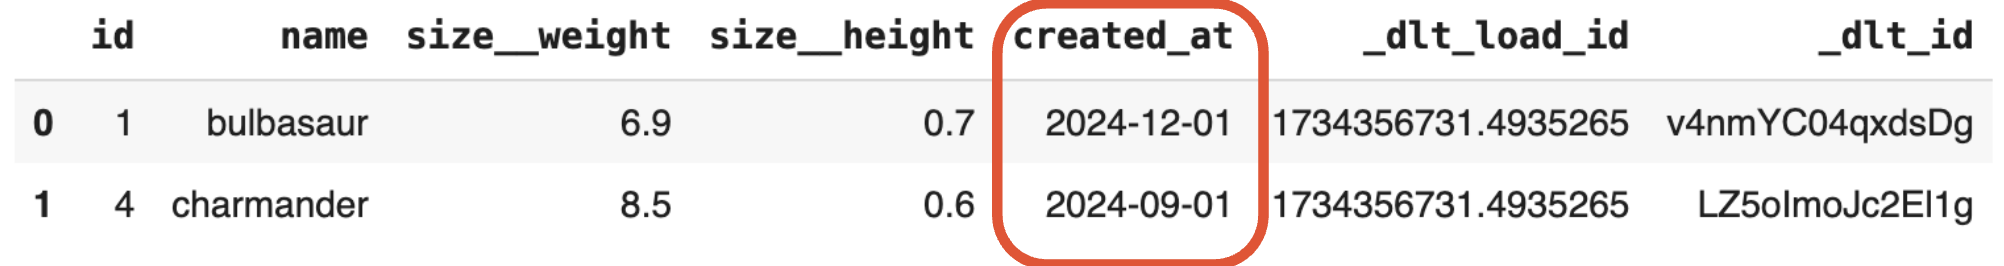

Run the same pipeline again. The pipeline will detect that there are **no new records** based on the `created_at` field and the incremental cursor. As a result, **no new data will be loaded** into the destination:
>0 load package(s) were loaded

In [11]:
load_info = pipeline.run(pokemon)
print(load_info)

Pipeline poke_pipeline_incremental load step completed in ---
0 load package(s) were loaded to destination duckdb and into dataset None
The duckdb destination used duckdb:////content/poke_pipeline_incremental.duckdb location to store data


### **Why incremental loading matters**

* **Efficiency**. Skip redundant data, saving time and resources.
* **Scalability**. Handle growing datasets without bottlenecks.
* **Automation**. Let the tool track changes for you—no manual effort.

## **Update and deduplicate your data**
The script above finds new pokemons and adds them to the database. It will ignore any updates to user information.

In [12]:
# We added `created_at` field to the data
data = [
    {
        "id": "1",
        "name": "bulbasaur",
        "size": {"weight": 6.9, "height": 0.7},
        "created_at": "2024-12-01",
        "updated_at": "2024-12-01"    # <------- new field
    },
    {
        "id": "4",
        "name": "charmander",
        "size": {"weight": 8.5, "height": 0.6},
        "created_at": "2024-09-01",
        "updated_at": "2024-09-01"    # <------- new field
    },
    {
        "id": "25",
        "name": "pikachu",
        "size": {"weight": 9, "height": 0.4}, # <----- pikachu gained weight from 6 to 9
        "created_at": "2023-06-01",
        "updated_at": "2024-12-16"    # <------- new field, information about pikachu has updated
    },
]

Get always fresh content of all the pokemons: combine an **incremental load** with **merge** write disposition, like in the script below.

In [13]:
import dlt

@dlt.resource(
    name="pokemon",
    write_disposition="merge",  # <--- change write disposition from 'append' to 'merge'
    primary_key="id",  # <--- set a primary key
)
def pokemon(cursor_date=dlt.sources.incremental("updated_at", initial_value="2024-01-01")):  # <--- change the cursor name from 'created_at' to 'updated_at'
    yield data


The incremental cursor keeps an eye on the `updated_at` field. Every time the pipeline runs, it only processes records with `updated_at` values greater than the last run.

In [14]:
pipeline = dlt.pipeline(
    pipeline_name="poke_pipeline_dedup",
    destination="duckdb",
    dataset_name="pokemon_data",
)

load_info = pipeline.run(pokemon)
print(load_info)

# explore loaded data
pipeline.dataset(dataset_type="default").pokemon.df()

Pipeline poke_pipeline_dedup load step completed in 0.35 seconds
1 load package(s) were loaded to destination duckdb and into dataset pokemon_data
The duckdb destination used duckdb:////content/poke_pipeline_dedup.duckdb location to store data
Load package 1741694853.132035 is LOADED and contains no failed jobs


,id,name,size__weight,size__height,created_at,updated_at,_dlt_load_id,_dlt_id
0,25,pikachu,9.0,0.4,2023-06-01,2024-12-16,1741694853.132035,LYYApvPqxGlV2w
1,1,bulbasaur,6.9,0.7,2024-12-01,2024-12-01,1741694853.132035,BEuHqvLy/de9yw
2,4,charmander,8.5,0.6,2024-09-01,2024-09-01,1741694853.132035,Bmx05fIfrZGlsA


All Pokémon are processed because this is the pipeline’s first run.

Now, let’s say Pikachu goes to gym and sheds some weight (down to 7.5), and the `updated_at` field is set to `2024-12-23`.

In [15]:
# We added `created_at` field to the data
data = [
    {
        "id": "1",
        "name": "bulbasaur",
        "size": {"weight": 6.9, "height": 0.7},
        "created_at": "2024-12-01",
        "updated_at": "2024-12-01"
    },
    {
        "id": "4",
        "name": "charmander",
        "size": {"weight": 8.5, "height": 0.6},
        "created_at": "2024-09-01",
        "updated_at": "2024-09-01"
    },
    {
        "id": "25",
        "name": "pikachu",
        "size": {"weight": 7.5, "height": 0.4}, # <--- pikachu lost weight
        "created_at": "2023-06-01",
        "updated_at": "2024-12-23"  # <--- data about his weight was updated a week later
    },
]

Run the same pipeline:

In [16]:
load_info = pipeline.run(pokemon)
print(load_info)

# explore loaded data
pipeline.dataset(dataset_type="default").pokemon.df()

Pipeline poke_pipeline_dedup load step completed in 0.18 seconds
1 load package(s) were loaded to destination duckdb and into dataset pokemon_data
The duckdb destination used duckdb:////content/poke_pipeline_dedup.duckdb location to store data
Load package 1741694862.4559286 is LOADED and contains no failed jobs


,id,name,size__weight,size__height,created_at,updated_at,_dlt_load_id,_dlt_id
0,1,bulbasaur,6.9,0.7,2024-12-01,2024-12-01,1741694853.132035,BEuHqvLy/de9yw
1,4,charmander,8.5,0.6,2024-09-01,2024-09-01,1741694853.132035,Bmx05fIfrZGlsA
2,25,pikachu,7.5,0.4,2023-06-01,2024-12-23,1741694862.4559286,gN1c7IHYJSs9AQ


**What happens?**

* The pipeline detects that `updated_at` for Bulbasaur and Charmander hasn’t changed—they’re skipped.
* Pikachu’s record is updated to reflect the latest weight.

You can see that the **`_dlt_load_id`** for Bulbasaur and Charmander remained the same, but for Pikachu it was changed since only the updated Pikachu data was loaded into the destination.

The **`dlt.sources.incremental`** instance above has the next attributes:

* **`cursor_date.initial_value`** which is always equal to "2024-01-01" passed in the constructor;
* **`cursor_date.start_value`** a maximum `updated_at` value from the previous run or the `initial_value` on the first run;
* **`cursor_date.last_value`** a "real-time" `updated_at` value updated with each yielded item or page. Before the first yield, it equals `start_value`;
* **`cursor_date.end_value`** (here not used) marking the end of the backfill range.

## **Example**
You can use them in the resource code to make **more efficient requests**. Take look at the GitHub API example:

In [17]:
exit() # we use exit() to reset all ENVs we set

In [1]:
import dlt
from dlt.sources.helpers import requests
from dlt.sources.helpers.rest_client import RESTClient
from dlt.sources.helpers.rest_client.auth import BearerTokenAuth
from dlt.sources.helpers.rest_client.paginators import HeaderLinkPaginator

import os
from google.colab import userdata

os.environ["SOURCES__ACCESS_TOKEN"] = userdata.get('SECRET_KEY')


@dlt.source
def github_source(access_token=dlt.secrets.value):
    client = RESTClient(
            base_url="https://api.github.com",
            auth=BearerTokenAuth(token=access_token),
            paginator=HeaderLinkPaginator(),
    )

    @dlt.resource(
        name="issues",
        write_disposition="merge",
        primary_key="id"
    )
    def github_issues(cursor_date=dlt.sources.incremental("updated_at", initial_value="2024-12-01")):
        params = {
            "since": cursor_date.last_value,  # <--- use last_value to request only new data from API
            "status": "open"
        }
        for page in client.paginate("repos/dlt-hub/dlt/issues", params=params):
            yield page


    return github_issues


# define new dlt pipeline
pipeline = dlt.pipeline(
    pipeline_name="github_incr",
    destination="duckdb"
)


# run the pipeline with the new resource
load_info = pipeline.run(github_source())
print(load_info)

Pipeline github_incr load step completed in 1.27 seconds
1 load package(s) were loaded to destination duckdb and into dataset github_incr_dataset
The duckdb destination used duckdb:////content/github_incr.duckdb location to store data
Load package 1741694908.214444 is LOADED and contains no failed jobs


Pay attention how we use **since** GitHub API parameter and `cursor_date.last_value` to tell GitHub which issues we are interested in. `cursor_date.last_value` holds the last `cursor_date` value from the previous run.

Run the pipeline again and make sure that **no data was loaded**.

In [2]:
# run the pipeline with the new resource
load_info = pipeline.run(github_source())
print(load_info)

Pipeline github_incr load step completed in ---
0 load package(s) were loaded to destination duckdb and into dataset None
The duckdb destination used duckdb:////content/github_incr.duckdb location to store data


## **Apply Hints**

Alternatively, you can use `apply_hints` on a resource to define an incremental field:

```python
resource = resource()
resource.apply_hints(incremental=dlt.sources.incremental("updated_at"))
```

When you apply an incremental hint using `apply_hints`, the source still performs a full extract. The incremental hint is used by `dlt` to filter the data after it has been extracted, before it is loaded into the destination.

## **Exercise 1: Make the GitHub API pipeline incremental**

In the previous lessons, you built a pipeline to pull data from the GitHub API. Now, let’s level it up by making it incremental, so it fetches only new or updated data.


Transform your GitHub API pipeline to use incremental loading. This means:

* Implement new `dlt.resource` for `pulls/comments` (List comments for Pull Requests) endpoint.
* Fetch only pulls comments updated after the last pipeline run.
* Use the `updated_at` field from the GitHub API as the incremental cursor.
* [Endpoint documentation](https://docs.github.com/en/rest/pulls/comments?apiVersion=2022-11-28#list-review-comments-in-a-repository)
* Endpoint URL: `https://api.github.com/repos/OWNER/REPO/pulls/comments`
* Use `since` parameter - only show results that were last updated after the given time - and `last_value`.
* `initial_value` is `2024-12-01`.


### Question

How many columns does the `comments` table have?

✅ ▶ Proceed to the [next lesson](https://colab.research.google.com/drive/1geSMNRkSwAelQJKd3e8vdoHCKiHMdmIo#forceEdit=true&sandboxMode=true)!

In [3]:
@dlt.source
def github_source(access_token=dlt.secrets.value):
    client = RESTClient(
        base_url="https://api.github.com",
        auth=BearerTokenAuth(token=access_token),
        paginator=HeaderLinkPaginator(),
    )

    @dlt.resource(
        name="issues",
        write_disposition="merge",
        primary_key="id"
    )
    def github_issues(cursor_date=dlt.sources.incremental("updated_at", initial_value="2024-12-01")):
        params = {
            "since": cursor_date.last_value,
            "status": "open"
        }
        for page in client.paginate("repos/dlt-hub/dlt/issues", params=params):
            yield page

    # New resource for pull request comments
    @dlt.resource(
        name="comments",
        write_disposition="merge",
        primary_key="id"
    )
    def github_pull_comments(cursor_date=dlt.sources.incremental("updated_at", initial_value="2024-12-01")):
        params = {
            "since": cursor_date.last_value,  # Use the incremental cursor
        }
        for page in client.paginate("repos/dlt-hub/dlt/pulls/comments", params=params):
            yield page

    return github_issues, github_pull_comments

# define new dlt pipeline
pipeline = dlt.pipeline(
    pipeline_name="github_incr",
    destination="duckdb"
)


# run the pipeline with the new resource
load_info = pipeline.run(github_source())
print(load_info)

Pipeline github_incr load step completed in 1.10 seconds
1 load package(s) were loaded to destination duckdb and into dataset github_incr_dataset
The duckdb destination used duckdb:////content/github_incr.duckdb location to store data
Load package 1741695250.7120502 is LOADED and contains no failed jobs


In [6]:
# explore loaded data
pipeline.dataset(dataset_type="default").comments.df()

,url,pull_request_review_id,id,node_id,diff_hunk,path,commit_id,original_commit_id,user__login,user__id,...,side,in_reply_to_id,original_position,position,subject_type,_dlt_load_id,_dlt_id,original_start_line,start_side,start_line
0,https://api.github.com/repos/dlt-hub/dlt/pulls...,2506053783,1886735511,PRRC_kwDOGvRYu85wdUyX,"@@ -52,6 +54,8 @@ class PipeIteratorConfigurat...",dlt/extract/pipe_iterator.py,9b9c9ece7cbb93b18f43b195f49bc2fa5ae4b243,9b9c9ece7cbb93b18f43b195f49bc2fa5ae4b243,joscha,188038,...,RIGHT,NaN,16,16.0,line,1741695250.7120502,n+kLSmHb/at5UQ,NaN,None,NaN
1,https://api.github.com/repos/dlt-hub/dlt/pulls...,2506219264,1886834898,PRRC_kwDOGvRYu85wdtDS,"@@ -3960,3 +3961,58 @@ def some_data(\n \n ...",tests/extract/test_incremental.py,fc013f591698fba41a6c3eda2e1c32997f68385b,9d38f56d1f3a34cb6e721955e185b03cf4ad29d0,joscha,188038,...,RIGHT,NaN,40,NaN,line,1741695250.7120502,Qp3KgsCtERv3+w,NaN,None,NaN
2,https://api.github.com/repos/dlt-hub/dlt/pulls...,2537473488,1907372889,PRRC_kwDOGvRYu85xsDNZ,"@@ -6,6 +6,8 @@ banned-modules = datetime = us...",tox.ini,84e78b91750a99f5e96d91003f9f96e105590e4c,8cebdf4063e4d745c75faf1a5dfd03bd1308b2d7,rudolfix,17202864,...,RIGHT,NaN,4,4.0,line,1741695250.7120502,4/WVujnXDkqD0Q,NaN,None,NaN
3,https://api.github.com/repos/dlt-hub/dlt/pulls...,2562863866,1922722074,PRRC_kwDOGvRYu85ymmka,"@@ -102,6 +103,18 @@ def close_connection(self...",dlt/destinations/impl/databricks/sql_client.py,428c075644368682c61f98ccb6f7bb690d217f5b,2bd0be005c95bce1ec1844c752ef934469d137db,rudolfix,17202864,...,RIGHT,NaN,13,NaN,line,1741695250.7120502,SB2XvxKdkYnZsw,NaN,None,NaN
4,https://api.github.com/repos/dlt-hub/dlt/pulls...,2562863866,1922722518,PRRC_kwDOGvRYu85ymmrW,"@@ -1,4 +1,6 @@\n [runtime]\n+log_level=""DEBUG""",tests/.dlt/config.toml,428c075644368682c61f98ccb6f7bb690d217f5b,2bd0be005c95bce1ec1844c752ef934469d137db,rudolfix,17202864,...,RIGHT,NaN,2,NaN,line,1741695250.7120502,HV1VWhxft/v3cg,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,https://api.github.com/repos/dlt-hub/dlt/pulls...,2637214643,1967708829,PRRC_kwDOGvRYu851SNqd,"@@ -348,3 +358,67 @@ def test_load_and_compare...",tests/common/test_json.py,c218cfb3a44ac2fb0d564c61aab9586bdea568e1,3e1f0fbcb1f52f161056d7573ebd5b78b82e2b76,joscha,188038,...,RIGHT,NaN,80,NaN,line,1741695250.7120502,OlXXHo012IeMrw,NaN,None,NaN
636,https://api.github.com/repos/dlt-hub/dlt/pulls...,2651473771,1975830968,PRRC_kwDOGvRYu851xMm4,"@@ -0,0 +1,305 @@\n+---\n+title: Advanced Proj...",docs/website/docs/plus/getting-started/advance...,46e180d46c9633e6de298057f3bf2fc6d8b4abcc,46e180d46c9633e6de298057f3bf2fc6d8b4abcc,burnash,264674,...,RIGHT,NaN,127,127.0,line,1741695250.7120502,tzNUYiqnb8N5eA,NaN,None,NaN
637,https://api.github.com/repos/dlt-hub/dlt/pulls...,2651528280,1975863253,PRRC_kwDOGvRYu851xUfV,"@@ -0,0 +1,305 @@\n+---\n+title: Advanced Proj...",docs/website/docs/plus/getting-started/advance...,46e180d46c9633e6de298057f3bf2fc6d8b4abcc,46e180d46c9633e6de298057f3bf2fc6d8b4abcc,burnash,264674,...,RIGHT,NaN,194,194.0,line,1741695250.7120502,e2pGKs0OEFu2rA,NaN,None,NaN
638,https://api.github.com/repos/dlt-hub/dlt/pulls...,2665109975,1983746754,PRRC_kwDOGvRYu852PZLC,"@@ -173,6 +182,64 @@ def _get_filtered_columns...",dlt/destinations/dataset/ibis_relation.py,070200a6e69b97e62c79ace79981bed3fad7c1f7,918635d5f73f507f62a860fa041994b08320055e,sh-rp,1155738,...,RIGHT,NaN,44,NaN,line,1741695250.7120502,9h7ZBY0XqUvpRQ,NaN,None,NaN
